In [1]:
# === Setup: libraries and config ===
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

# Load config.yaml
CONFIG_PATH = Path("../../config.yaml").resolve()

try:
    with CONFIG_PATH.open("r", encoding="utf-8") as f:
        config = yaml.safe_load(f)
    print(f"Config loaded successfully from: {CONFIG_PATH}")
except Exception as e:
    raise FileNotFoundError(f"config.yaml not found at {CONFIG_PATH}") from e

print("Top-level keys:", list(config.keys()))

# === Load clean dataframe (df_full) ===
clean_cfg = config.get("data", {}).get("clean", {})
if "df_full" not in clean_cfg:
    raise KeyError("'df_full' is not defined in config['data']['clean']")

# --- Resolve path relative to config.yaml parent, stripping leading ../ ---
yaml_path = Path(clean_cfg["df_full"])
if yaml_path.is_absolute():
    path = yaml_path
else:
    parts = list(yaml_path.parts)
    while parts and parts[0] in ("..", "."):
        parts = parts[1:]
    rel = Path(*parts)  # e.g., "data/clean_data_txt/df_full.pkl"
    path = (CONFIG_PATH.parent / rel).resolve()

print("Resolved df_full path:", path)

if not path.exists():
    raise FileNotFoundError(f"File not found at: {path}")

df_full = pd.read_pickle(path)
print(f"df_full loaded successfully: {df_full.shape}")
display(df_full.head())


  

Config loaded successfully from: C:\Users\Gustavo\Documents\Irma\Ironhack\SEMANA 5\project_2\vanguard-ab-test\config.yaml
Top-level keys: ['data']
Resolved df_full path: C:\Users\Gustavo\Documents\Irma\Ironhack\SEMANA 5\project_2\vanguard-ab-test\data\clean_data_txt\df_full.pkl
df_full loaded successfully: (747573, 14)


,client_id,visitor_id,visit_id,process_step,date_time,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,5.0,60.0,79.0,U,2.0,189023.86,1.0,4.0
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,5.0,60.0,79.0,U,2.0,189023.86,1.0,4.0
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,5.0,60.0,79.0,U,2.0,189023.86,1.0,4.0
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,5.0,60.0,79.0,U,2.0,189023.86,1.0,4.0
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,5.0,60.0,79.0,U,2.0,189023.86,1.0,4.0


In [6]:
# Clean and standardize gender column
# "U" and "X" represent unspecified or unknown gender, so they are grouped as "Unknown"

df_full['gendr_clean'] = df_full['gendr'].replace({'U': 'Unknown', 'X': 'Unknown'})


In [8]:
# Create Age Groups
bins = [18, 25, 35, 45, 55, 65, 75, 100]
labels = ['18–25', '26–35', '36–45', '46–55', '56–65', '66–75', '76+']
df_full['age_group'] = pd.cut(df_full['clnt_age'], bins=bins, labels=labels, right=False)


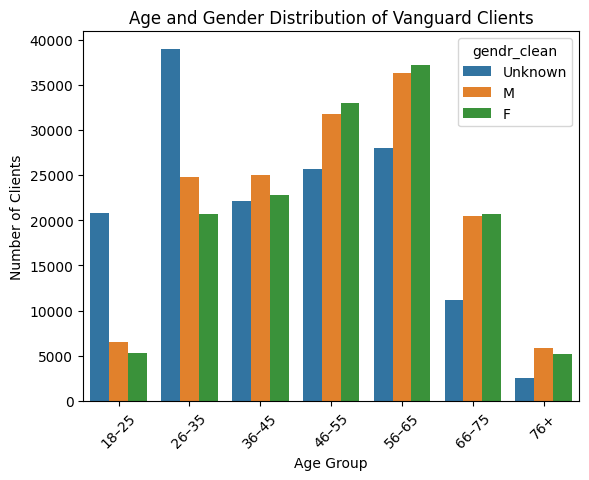

In [9]:
# Visualize the distribution of clients by age and gender
# Using the cleaned column 'gendr_clean' for consistent gender categories

sns.countplot(data=df_full, x='age_group', hue='gendr_clean')
plt.title("Age and Gender Distribution of Vanguard Clients")
plt.xlabel("Age Group")
plt.ylabel("Number of Clients")
plt.xticks(rotation=45)
plt.show()


In [12]:
# Group by client to check how many visits each person made
# Keeps each client_id once, showing their gender, age group, and total number of visits
# Helps understand engagement level (how often clients use the online process)

client_demo = (
    df_full
    .groupby(['client_id', 'gendr_clean', 'age_group'], observed=True)
    .size()
    .reset_index(name='visits')
)

display(client_demo.head(10))  # <-- muestra algo
len(client_demo)               # <-- cuántos clientes únicos hay en la tabla



,client_id,gendr_clean,age_group,visits
0,169,M,46–55,5
1,555,Unknown,26–35,5
2,647,M,56–65,5
3,722,F,56–65,9
4,934,F,46–55,4
5,1028,M,36–45,9
6,1104,Unknown,46–55,1
7,1186,Unknown,18–25,4
8,1195,M,46–55,5
9,1197,Unknown,26–35,7


69903

In [13]:
# Calculate percentage distribution of unique clients by age group and gender
# This shows the share of each gender within every age range

age_gender_counts = (
    df_full
    .groupby(['age_group','gendr_clean'], observed=True)['client_id']
    .nunique()
    .reset_index(name='n_clients')
)

total_per_group = (
    df_full
    .groupby('age_group', observed=True)['client_id']
    .nunique()
    .reset_index(name='total_clients')
)

age_gender_perc = age_gender_counts.merge(total_per_group, on='age_group')
age_gender_perc['pct'] = (age_gender_perc['n_clients'] / age_gender_perc['total_clients'] * 100).round(2)

display(age_gender_perc.sort_values(['age_group','gendr_clean']).head(20))


,age_group,gendr_clean,n_clients,total_clients,pct
0,18–25,F,897,5515,16.26
1,18–25,M,1093,5515,19.82
2,18–25,Unknown,3525,5515,63.92
3,26–35,F,3596,14504,24.79
4,26–35,M,4267,14504,29.42
5,26–35,Unknown,6641,14504,45.79
6,36–45,F,3907,11828,33.03
7,36–45,M,4213,11828,35.62
8,36–45,Unknown,3708,11828,31.35
9,46–55,F,5100,14137,36.08


## 🧠 Conclusion – Client Demographics Analysis

1️⃣ Who are the primary clients using this online process?

The analysis shows that the majority of clients using Vanguard’s online process are between 46 and 65 years old, with the two most dominant groups being 46–55 and 56–65.
This indicates that the platform is mainly used by middle-aged and pre-retirement clients, who are typically at their peak investment stage.
Regarding gender, the distribution between males and females is relatively balanced; however, around 30–40% of users fall under the “Unknown” gender category, which may reflect missing demographic data or anonymization for privacy reasons.
This highlights that Vanguard’s online users are mostly experienced, mature investors rather than young newcomers.

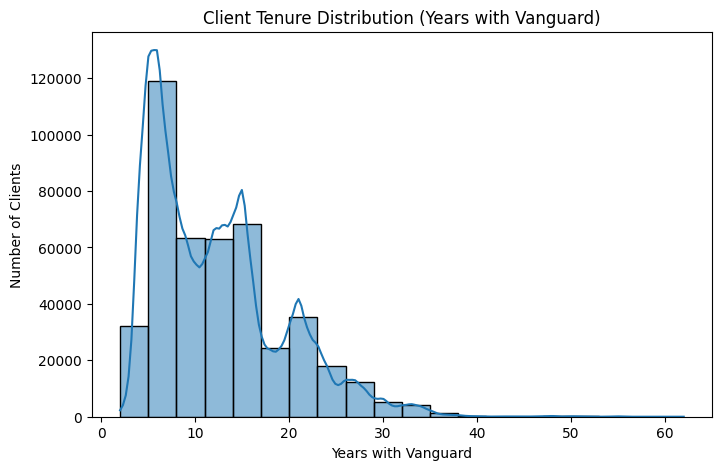

count    447157.000000
mean         12.233140
std           7.004369
min           2.000000
25%           6.000000
50%          11.000000
75%          16.000000
max          62.000000
Name: clnt_tenure_yr, dtype: float64

In [14]:
# Analyze client tenure to understand how long clients have been with Vanguard.
# This helps identify whether the main users of the online process are new or long-standing clients.

plt.figure(figsize=(8,5))
sns.histplot(data=df_full, x='clnt_tenure_yr', bins=20, kde=True)
plt.title("Client Tenure Distribution (Years with Vanguard)")
plt.xlabel("Years with Vanguard")
plt.ylabel("Number of Clients")
plt.show()

# Calculate summary statistics
tenure_summary = df_full['clnt_tenure_yr'].describe()
display(tenure_summary)


## 2️⃣ Are the primary clients younger or older, new or long-standing?
The tenure analysis shows that most clients have been with Vanguard for an average of 12 years, with 50% (median) having at least 11 years of relationship.
The majority of clients fall between 6 and 16 years of tenure, while very few have less than 2 years or more than 30.
This indicates that the online platform is primarily used by long-standing, experienced clients, rather than newcomers.
The stability and maturity of these users align with Vanguard’s typical investor profile — loyal clients with consistent engagement over time.
